<a href="https://colab.research.google.com/github/VienneseWaltz/Supervised_Learning/blob/main/supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utility functions

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV
import time

def load_wine_quality_data(filename):
    """
    Loading the wine_quality.csv file
    :param filename: path to the csv file
    :return: X (data) and y (labels)
    """
    data = pd.read_csv(filename)
    data.loc[(data.quality == 'good'), 'quality'] = 1
    data.loc[(data.quality == 'bad'), 'quality'] = 0

    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].values.astype(int)

    return X, y


def load_Star3642_balanced_data(filename):
    """
    Loading the Star3642_balanced.csv file
    :param filename: path to the csv file
    :return: X (data) and y (labels)
    """

    # For this dataset, if the target column shows '1', it is a Giant star
    # and a '0' indicates a Dwarf star
    data = pd.read_csv(filename)
    # Map colum 'SpType' from string to integer.
    mapping = {k: v for v, k in enumerate(data.SpType.unique())}
    data['SpType'] = data.SpType.map(mapping)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].values.astype(int)

    return X, y


def report_training_result(model_type, dataset_name, y_train, y_train_pred, y_test, y_test_pred):
    print(f"Classification report of {model_type} for {dataset_name} training data")
    print(classification_report(y_train, y_train_pred))
    print(f"Classification report of {model_type} for {dataset_name} testing data")
    print(classification_report(y_test, y_test_pred))

    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Accuracy of {model_type} for {dataset_name} training data is {'%.4f' % (train_accuracy)}")
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy of {model_type} for {dataset_name} testing data is {'%.4f' % (test_accuracy)}")

    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    print(f"AUC of {model_type} for {dataset_name} training data = {round(train_auc, 4)}")
    print(f"AUC of {model_type} for {dataset_name} testing data = {round(test_auc, 4)}")

Read in datasets.

In [ ]:
model_type = []
training_time = []
testing_time = []

X1, y1 = load_wine_quality_data("wine_quality.csv")
X2, y2 = load_Star3642_balanced_data("Star3642_balanced.csv")

Decision tree learning

In [ ]:
from sklearn import tree

def decision_tree_learning(dataset_name, X, y, saveFig=False, verbose=False):
    # Preprocessing the data
    X = preprocessing.scale(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a decision tree classifier using the default hyperparameters.
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=8, class_weight='balanced')
    dt.fit(X_train, y_train)
    y_test_pred = dt.predict(X_test)
    y_train_pred = dt.predict(X_train)
    report_training_result("decision tree (default)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Plot validation curves over hyperparameter max_leaf_nodes and min_samples_split.
    # Validation curve help evaluate if the model is overfitting or underfitting.
    max_leaf_nodes_range = np.arange(2, 100, 1)
    train_score, test_score = validation_curve(dt, X_train, y_train, param_name="max_leaf_nodes",
                                               param_range=max_leaf_nodes_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(max_leaf_nodes_range, mean_train_score, label="Training score", color='b')
    plt.plot(max_leaf_nodes_range, mean_test_score, label="Cross-validation score", color='g')
    plt.grid()
    plt.title('Validataion curve for decision tree (Max leaf nodes) for ' + dataset_name, fontweight="bold")
    plt.xlabel('Maximum Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'best')
    if saveFig:
        fig1 = plt.gcf()
        fig1.savefig('figure/ValidationCurve_dt(max_leaf_nodes)' + '_' + dataset_name +'.png', format='png', dpi=120)
        plt.close(fig1)
    else:
        plt.show()

    min_samples_leaf_range = np.arange(2, 100, 1)
    train_score, test_score = validation_curve(dt, X_train, y_train,param_name="min_samples_leaf",
                                               param_range=min_samples_leaf_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(min_samples_leaf_range, mean_train_score, label='Training score' , color='c')
    plt.plot(min_samples_leaf_range, mean_test_score, label='Cross-validation score', color='m')
    plt.grid()
    plt.title('Validataion curve for decision tree(min_samples_leaf) for ' + dataset_name, fontweight="bold")
    plt.xlabel('Minimum Samples at Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    if saveFig:
        fig2 = plt.gcf()
        fig2.savefig('figure/ValidationCurve_dt(min_samples_leaf)' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig2)
    else:
        plt.show()

    # Plot learning curve to find out if the model would benefit from more training data.
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(dt, X_train, y_train,
                                                            train_sizes=train_sizes, cv=5)
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(train_sizes, mean_train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, mean_test_scores, 'o-', color='g', label='Cross-validation score')
    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.title('Learning curve for decision tree for ' + dataset_name, fontweight="bold")
    plt.legend(loc='best')
    if saveFig:
        fig3 = plt.gcf()
        fig3.savefig('figure/LearningCurve_dt' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig3)
    else:
        plt.show()

    # Tune the model over hyperparameter max_leaf_nodes, min_samples_leaf, and ccp_alpha.
    # Note that ccp_alpha tuning is for tree pruning to reduce model overfitting.
    ccp_pruning_path = dt.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas_range = ccp_pruning_path['ccp_alphas']
    params_to_tune = {'max_leaf_nodes': max_leaf_nodes_range,
                      'min_samples_leaf': min_samples_leaf_range,
                      'ccp_alpha': ccp_alphas_range}
    grid_dt = GridSearchCV(estimator=dt, param_grid=params_to_tune, scoring='accuracy', cv=5, verbose=1, n_jobs=8)

    t0 = time.time()
    grid_dt.fit(X_train, y_train)
    t1 = time.time()
    training_time = t1 - t0
    print(f'Training time for decision tree classifier for {dataset_name}: {training_time} seconds')

    best_dt_params = grid_dt.best_params_
    print(f'The best decision tree parameters for {dataset_name} found are: {best_dt_params}')

    if verbose:
        print(f"Grid search scores on training data for {dataset_name}:")
        means = grid_dt.cv_results_['mean_test_score']
        stds = grid_dt.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_dt.cv_results_['params']):
            print(f"{'%0.3f' % (mean)} (+/-{'%0.03f' % (std * 2)}) for {'%r' % (params)}")

    t0 = time.time()
    y_test_pred = grid_dt.predict(X_test)
    t1 = time.time()
    testing_time = t1 - t0
    print(f'Inference time for decision tree classifier for {dataset_name}: {testing_time} seconds')

    y_train_pred = grid_dt.predict(X_train)

    report_training_result("decision tree (optimized)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    return training_time, testing_time


Classification report of decision tree (default) for wine_quality training data
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       603
           1       0.79      0.74      0.76       676

    accuracy                           0.76      1279
   macro avg       0.76      0.76      0.76      1279
weighted avg       0.76      0.76      0.76      1279

Classification report of decision tree (default) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       141
           1       0.78      0.70      0.74       179

    accuracy                           0.72       320
   macro avg       0.72      0.73      0.72       320
weighted avg       0.73      0.72      0.72       320

Accuracy of decision tree (default) for wine_quality training data is 0.7584
Accuracy of decision tree (default) for wine_quality testing data is 0.7219
AUC of decision tree (default) for

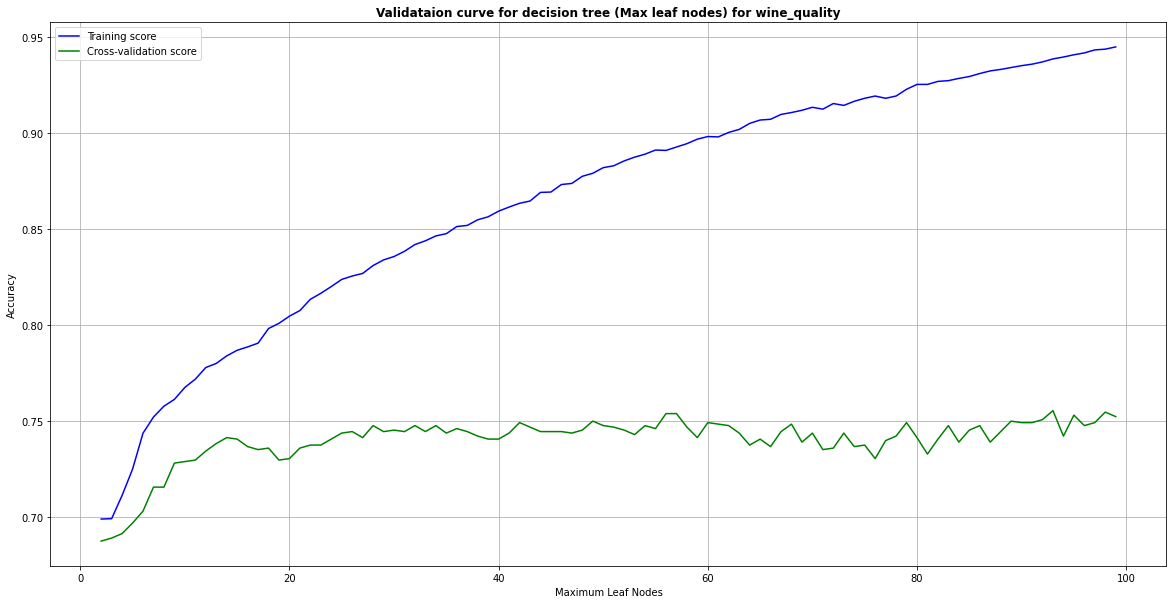

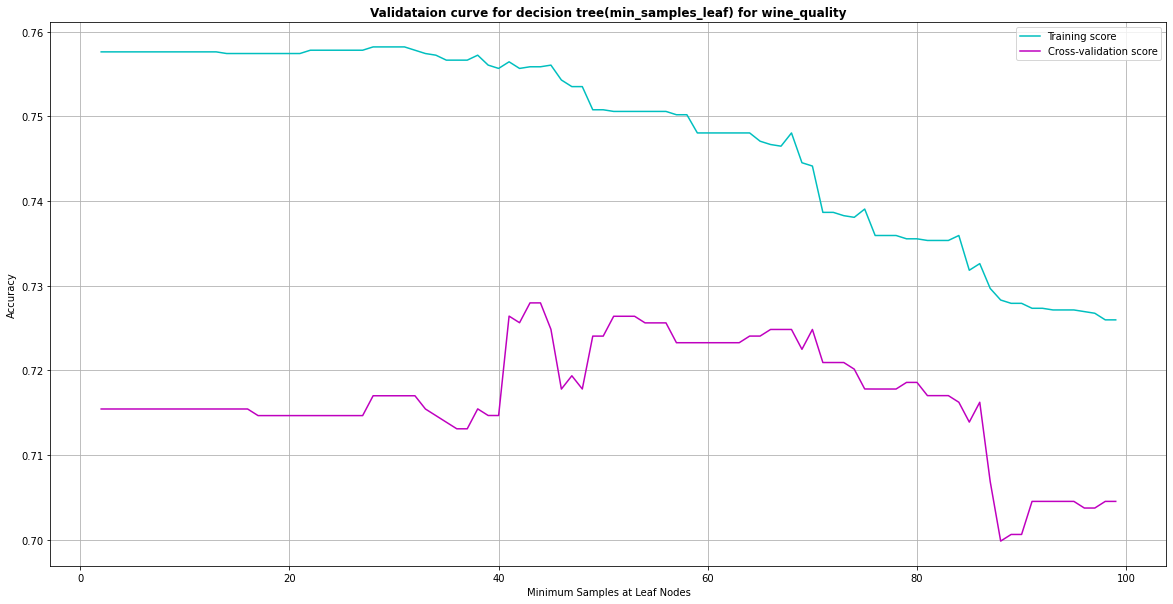

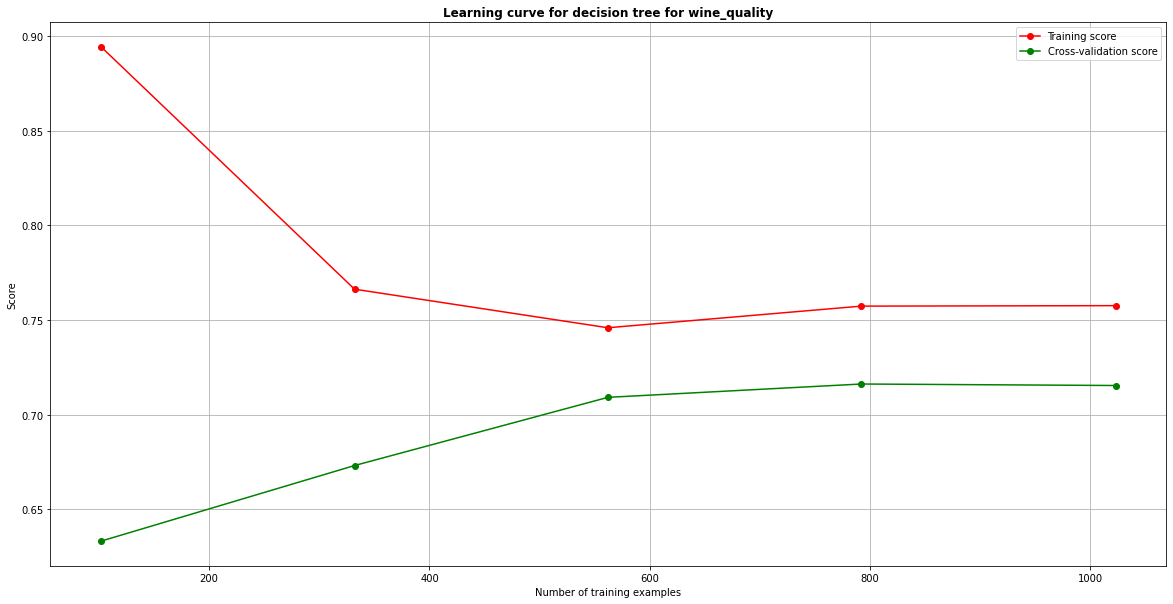

Fitting 5 folds for each of 76832 candidates, totalling 384160 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 976 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 2976 tasks      | elapsed:   10.2s
[Parallel(n_jobs=8)]: Done 5776 tasks      | elapsed:   18.1s
[Parallel(n_jobs=8)]: Done 9376 tasks      | elapsed:   28.7s
[Parallel(n_jobs=8)]: Done 13776 tasks      | elapsed:   41.9s
[Parallel(n_jobs=8)]: Done 18976 tasks      | elapsed:   57.9s
[Parallel(n_jobs=8)]: Done 24976 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 31776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 39376 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 47776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 56976 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 66976 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 77776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 89376 tasks      | elap

Training time for decision tree classifier for wine_quality: 1195.4131033420563 seconds
The best decision tree parameters for wine_quality found are: {'ccp_alpha': 0.0, 'max_leaf_nodes': 50, 'min_samples_leaf': 2}
Inference time for decision tree classifier for wine_quality: 0.0014255046844482422 seconds
Classification report of decision tree (optimized) for wine_quality training data
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       603
           1       0.89      0.86      0.87       676

    accuracy                           0.87      1279
   macro avg       0.87      0.87      0.87      1279
weighted avg       0.87      0.87      0.87      1279

Classification report of decision tree (optimized) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       141
           1       0.77      0.72      0.75       179

    accuracy                           0

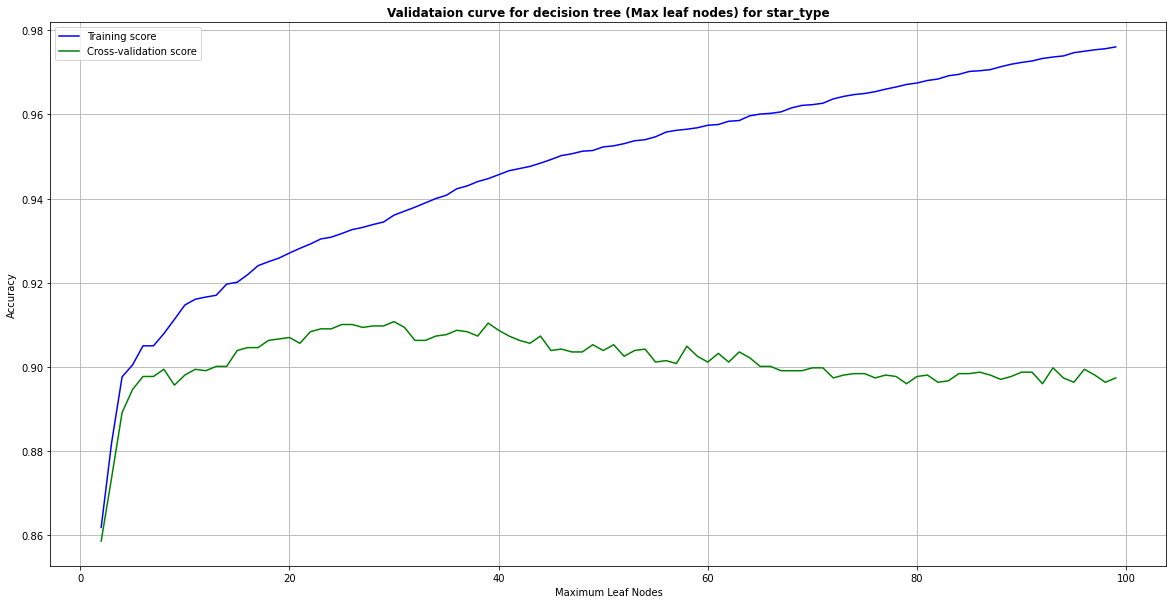

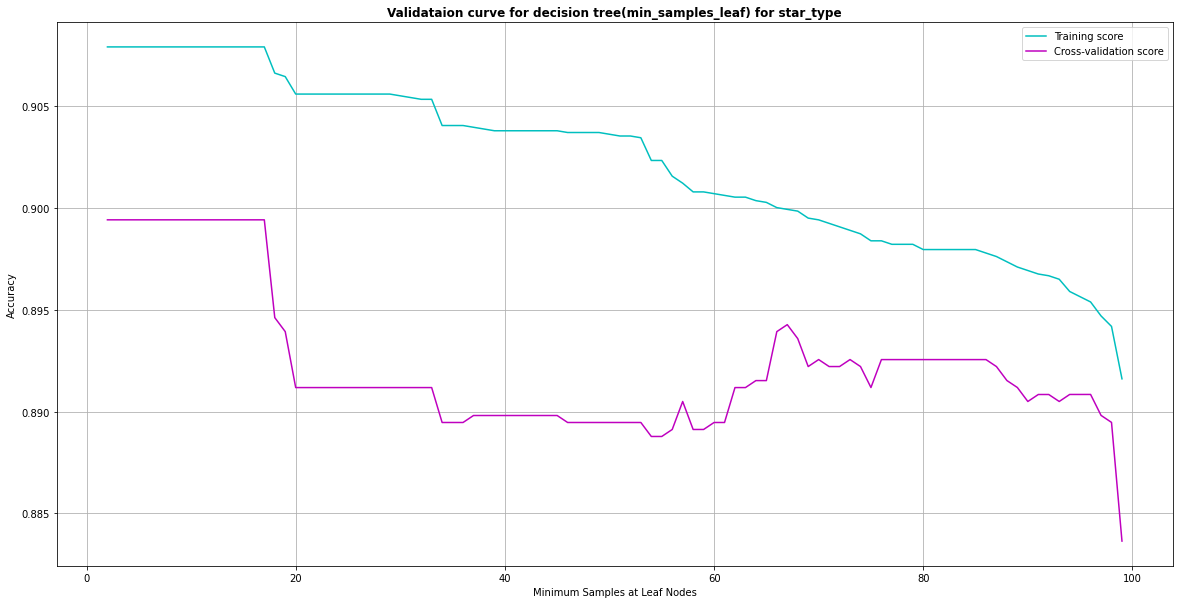

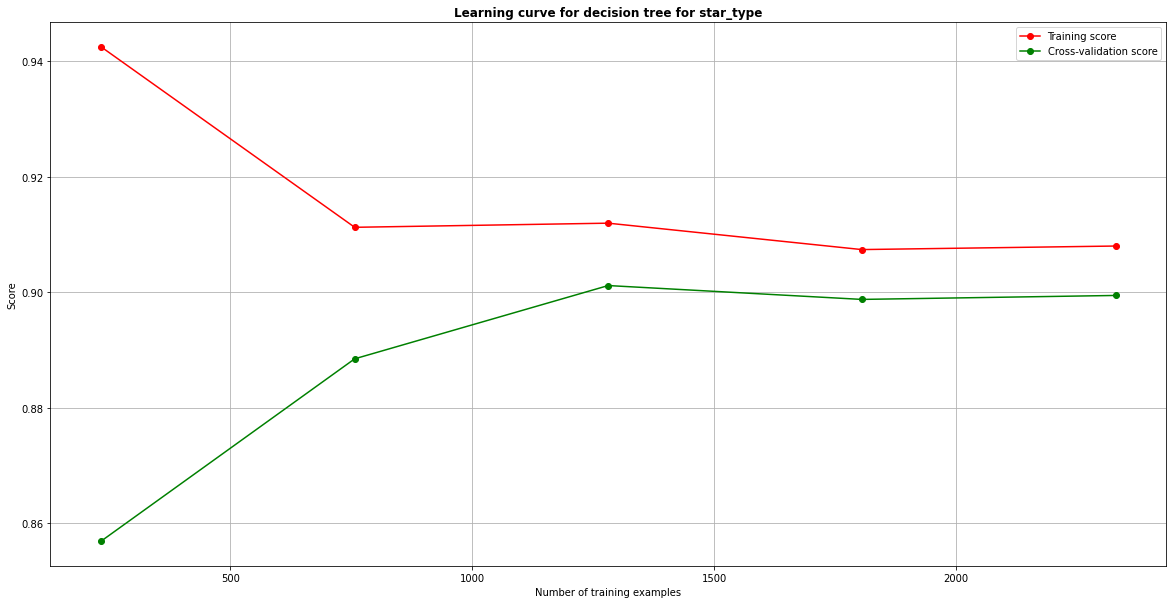

Fitting 5 folds for each of 67228 candidates, totalling 336140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   26.8s
[Parallel(n_jobs=8)]: Done 9600 tasks      | elapsed:   45.9s
[Parallel(n_jobs=8)]: Done 14000 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 19200 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 25200 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 32000 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 39600 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 48000 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 57200 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done 67200 tasks      | elapsed:  6.2min
[Parallel(n_jobs=8)]: Done 78000 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 89600 tasks      | ela

Training time for decision tree classifier for star_type: 1920.6208114624023 seconds
The best decision tree parameters for star_type found are: {'ccp_alpha': 0.0, 'max_leaf_nodes': 30, 'min_samples_leaf': 2}
Inference time for decision tree classifier for star_type: 0.0015368461608886719 seconds
Classification report of decision tree (optimized) for star_type training data
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1468
           1       0.93      0.94      0.94      1445

    accuracy                           0.94      2913
   macro avg       0.94      0.94      0.94      2913
weighted avg       0.94      0.94      0.94      2913

Classification report of decision tree (optimized) for star_type testing data
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       353
           1       0.91      0.91      0.91       376

    accuracy                           0.91       729
 

In [ ]:
# Decision tree learning
training_time1, testing_time1 = decision_tree_learning("wine_quality", X1, y1, saveFig=False, verbose= False)
training_time2, testing_time2 = decision_tree_learning("star_type", X2, y2, saveFig=False, verbose= False)
model_type.append("Decision Tree")
training_time.append(training_time1 + training_time2)
testing_time.append(testing_time1 + testing_time2)



Neural network learning

In [ ]:
from sklearn.neural_network import MLPClassifier

def neural_network_learning(dataset_name, X, y, saveFig=False, verbose=False):
    # Preprocessing the data
    std_scaler = preprocessing.StandardScaler()
    X = std_scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use a default neural network with 2 hidden layers of size 5 and 2.
    nn = MLPClassifier(hidden_layer_sizes = (5,2), random_state = 7, max_iter = 1000)
    nn.fit(X_train, y_train)
    y_test_pred = nn.predict(X_test)
    y_train_pred = nn.predict(X_train)
    report_training_result("neural network (default)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Plot validation curves over hyperparameter alpha and learning_rate.
    # Validation curve help evaluate if the model is overfitting or underfitting.
    alpha_range = np.logspace(-1, 1, 10)
    train_score, test_score = validation_curve(nn, X_train, y_train, param_name="alpha",
                                               param_range=alpha_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.semilogx(alpha_range, mean_train_score, label="Training score", color='b')
    plt.semilogx(alpha_range, mean_test_score, label="Cross-validation score", color='g')
    plt.grid()
    plt.title('Validataion curve for neural network (alpha) for ' + dataset_name, fontweight="bold")
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.legend(loc = 'best')
    if saveFig:
        fig1 = plt.gcf()
        fig1.savefig('figure/ValidationCurve_nn(alpha)' + '_' + dataset_name +'.png', format='png', dpi=120)
        plt.close(fig1)
    else:
        plt.show()

    learning_rate_init_range = np.logspace(-8, -1, 8)
    train_score, test_score = validation_curve(nn, X_train, y_train, param_name="learning_rate_init",
                                               param_range=learning_rate_init_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.semilogx(learning_rate_init_range, mean_train_score, label="Training score", color='b')
    plt.semilogx(learning_rate_init_range, mean_test_score, label="Cross-validation score", color='g')
    plt.grid()
    plt.title('Validataion curve for neural network (learning_rate) for ' + dataset_name, fontweight="bold")
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.legend(loc = 'best')
    if saveFig:
        fig1 = plt.gcf()
        fig1.savefig('figure/ValidationCurve_nn(learning_rate)' + '_' + dataset_name +'.png', format='png', dpi=120)
        plt.close(fig1)
    else:
        plt.show()

    # Plot learning curve to find out if the model would benefit from more training data.
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(nn, X_train, y_train,
                                                            train_sizes=train_sizes, cv=5)
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(train_sizes, mean_train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, mean_test_scores, 'o-', color='g', label='Cross-validation score')
    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.title('Learning curve for neural network for ' + dataset_name, fontweight="bold")
    plt.legend(loc='best')
    if saveFig:
        fig3 = plt.gcf()
        fig3.savefig('figure/LearningCurve_nn' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig3)
    else:
        plt.show()

    # Tune the model over hyperparameter alpha and learning_rate.
    # Note that ccp_alpha tuning is for tree pruning to reduce model overfitting.
    hidden_layer_sizes_range = [(10, 8, 6, 2), (10, 5, 2)]
    params_to_tune = {'alpha': alpha_range,
                      'learning_rate_init': learning_rate_init_range,
                      'hidden_layer_sizes': hidden_layer_sizes_range}
    grid_nn = GridSearchCV(estimator=nn, param_grid=params_to_tune, scoring='accuracy', cv=5, verbose=1, n_jobs=8)

    t0 = time.time()
    grid_nn.fit(X_train, y_train)
    t1 = time.time()
    training_time = t1 - t0
    print(f'Training time for neural network classifier for {dataset_name}: {training_time} seconds')

    best_nn_params = grid_nn.best_params_
    print(f'The best neural network parameters for {dataset_name} found are: {best_nn_params}')

    if verbose:
        print(f"Grid search scores on training data for {dataset_name}:")
        means = grid_nn.cv_results_['mean_test_score']
        stds = grid_nn.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_nn.cv_results_['params']):
            print(f"{'%0.3f' % (mean)} (+/-{'%0.03f' % (std * 2)}) for {'%r' % (params)}")

    t0 = time.time()
    y_test_pred = grid_nn.predict(X_test)
    t1 = time.time()
    testing_time = t1 - t0
    print(f'Inference time for neural network classifier for {dataset_name}: {testing_time} seconds')

    y_train_pred = grid_nn.predict(X_train)

    report_training_result("neural network (optimized)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Plot training loss curve over the number of training epochs.
    nn = MLPClassifier(random_state=7, max_iter=1000, warm_start=True)
    nn.set_params(hidden_layer_sizes=grid_nn.best_params_['hidden_layer_sizes'],
                  alpha=grid_nn.best_params_['alpha'],
                  learning_rate_init=grid_nn.best_params_['learning_rate_init'])
    nn.fit(X_train, y_train)
    plt.figure(figsize=(20,10))
    plt.plot(nn.loss_curve_)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel("Loss")
    plt.title('Training loss curve for neural network for ' + dataset_name,  fontweight="bold")
    if saveFig:
        fig4 = plt.gcf()
        fig4.savefig('figure/LossCurve_nn' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig4)
    else:
        plt.show()

    return training_time, testing_time


Classification report of neural network (default) for wine_quality training data
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       603
           1       0.78      0.79      0.79       676

    accuracy                           0.77      1279
   macro avg       0.77      0.77      0.77      1279
weighted avg       0.77      0.77      0.77      1279

Classification report of neural network (default) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       141
           1       0.79      0.79      0.79       179

    accuracy                           0.77       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.77      0.77      0.77       320

Accuracy of neural network (default) for wine_quality training data is 0.7748
Accuracy of neural network (default) for wine_quality testing data is 0.7656
AUC of neural network (default

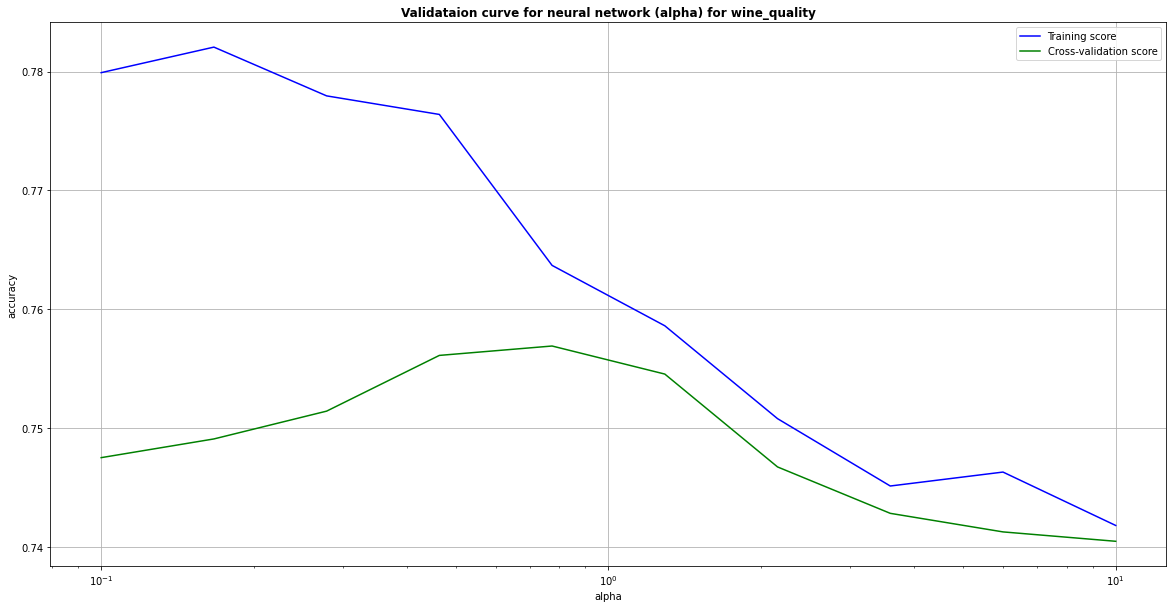

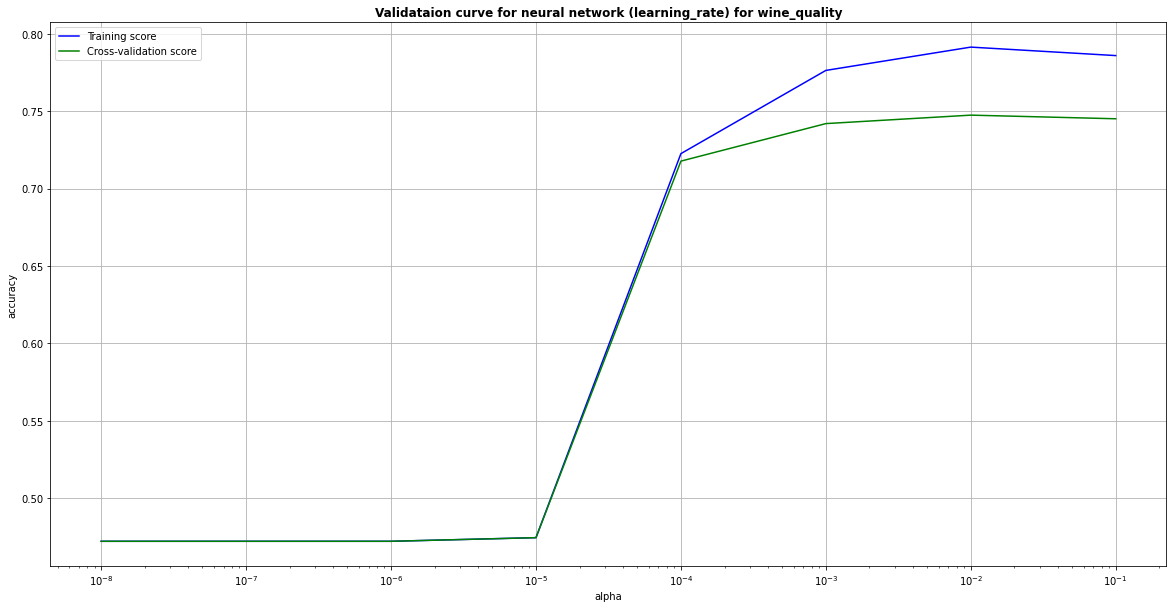

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

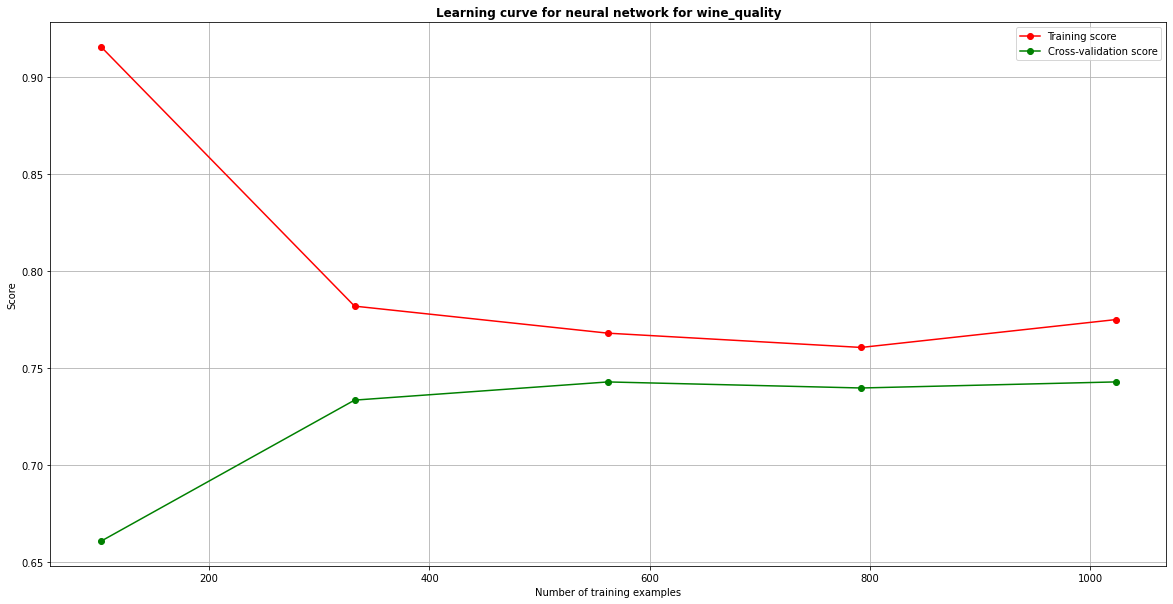

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed:  7.0min finished


Training time for neural network classifier for wine_quality: 425.6883292198181 seconds
The best neural network parameters for wine_quality found are: {'alpha': 0.16681005372000587, 'hidden_layer_sizes': (10, 5, 2), 'learning_rate_init': 0.001}
Inference time for neural network classifier for wine_quality: 0.0004024505615234375 seconds
Classification report of neural network (optimized) for wine_quality training data
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       603
           1       0.89      0.79      0.84       676

    accuracy                           0.84      1279
   macro avg       0.84      0.84      0.84      1279
weighted avg       0.84      0.84      0.84      1279

Classification report of neural network (optimized) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       141
           1       0.81      0.73      0.77       179

    ac

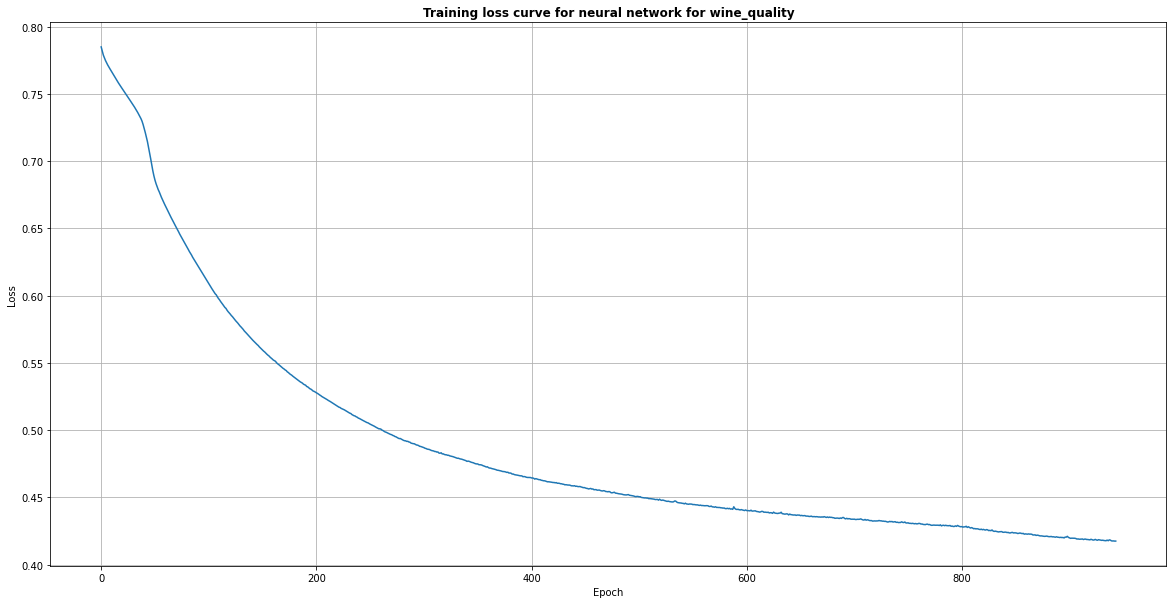

Classification report of neural network (default) for star_type training data
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1468
           1       0.91      0.90      0.90      1445

    accuracy                           0.90      2913
   macro avg       0.90      0.90      0.90      2913
weighted avg       0.90      0.90      0.90      2913

Classification report of neural network (default) for star_type testing data
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       353
           1       0.89      0.88      0.89       376

    accuracy                           0.88       729
   macro avg       0.88      0.88      0.88       729
weighted avg       0.88      0.88      0.88       729

Accuracy of neural network (default) for star_type training data is 0.9035
Accuracy of neural network (default) for star_type testing data is 0.8834
AUC of neural network (default) for star_t

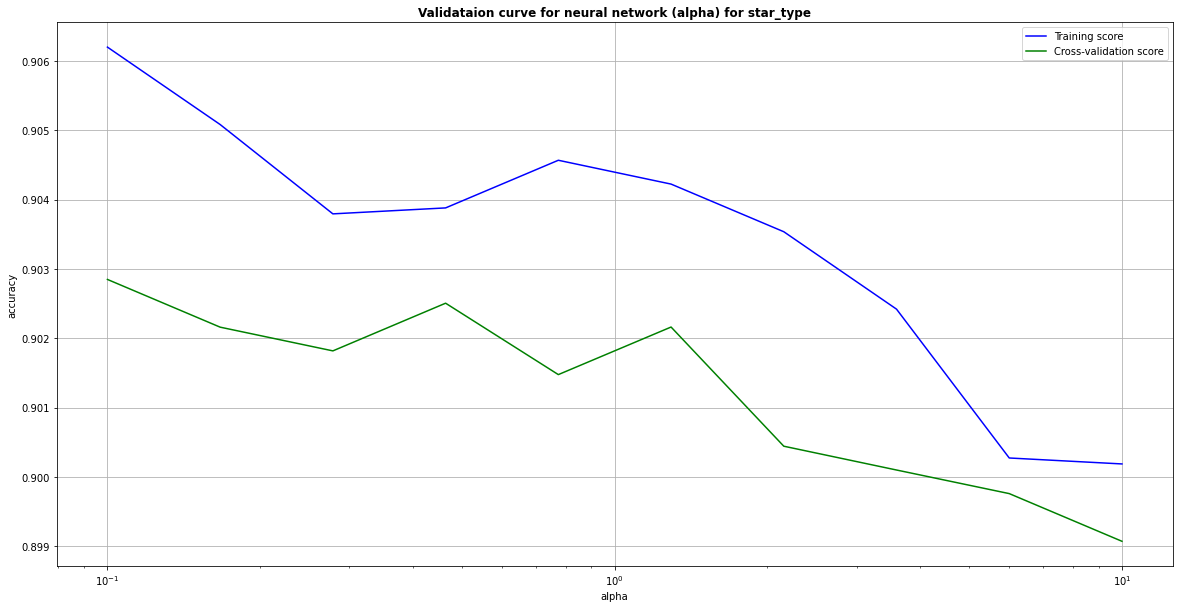

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

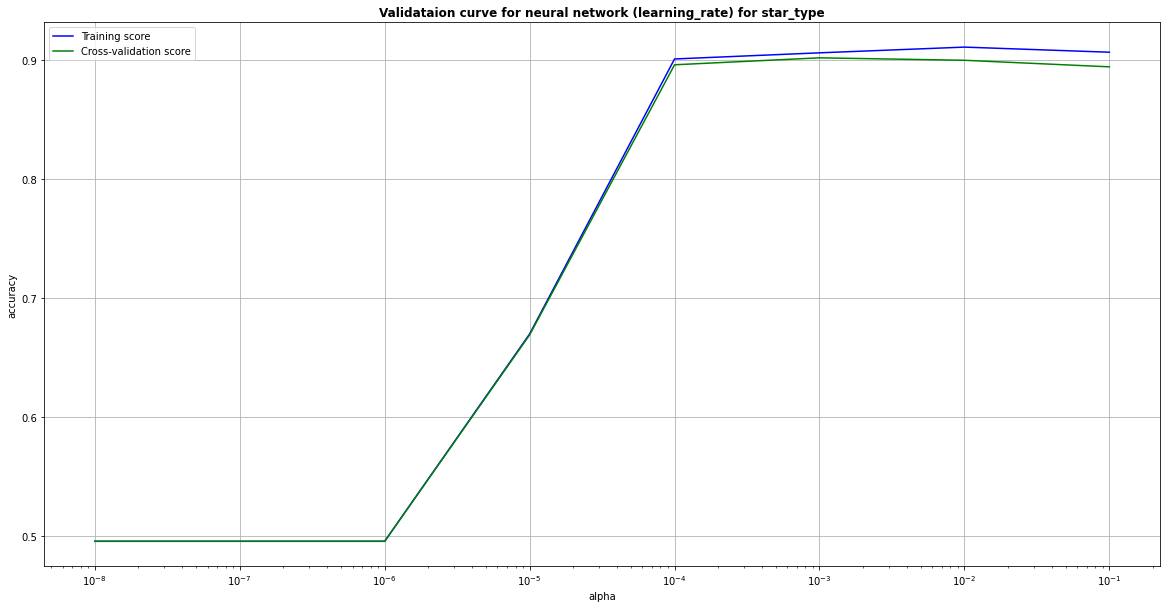

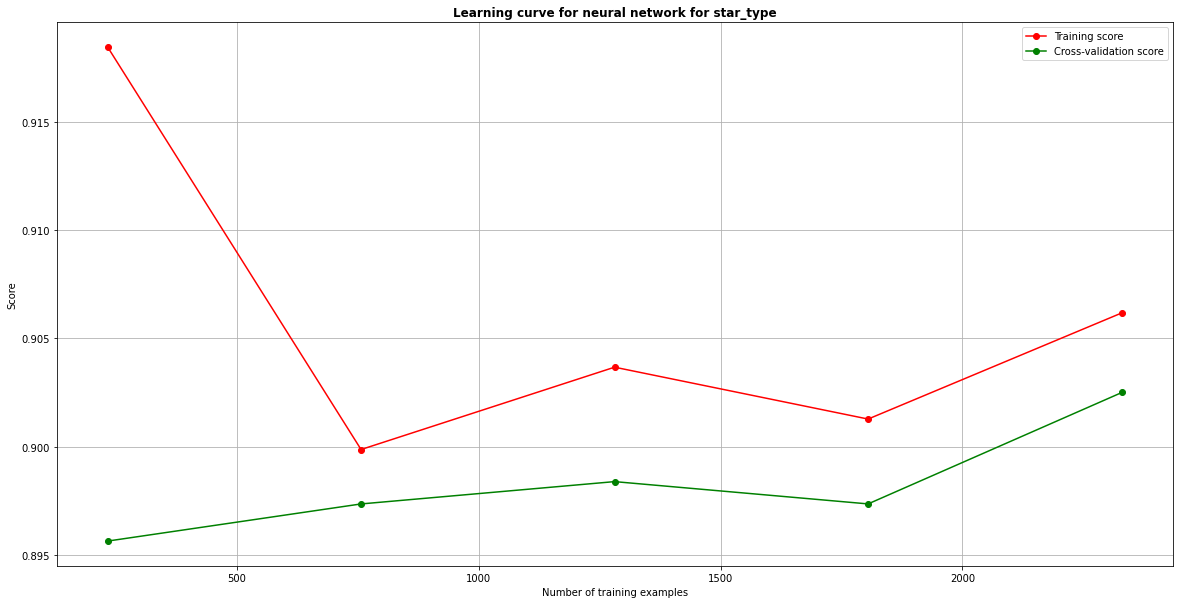

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  9.7min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 17.3min
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed: 17.4min finished


Training time for neural network classifier for star_type: 1047.2205257415771 seconds
The best neural network parameters for star_type found are: {'alpha': 0.16681005372000587, 'hidden_layer_sizes': (10, 8, 6, 2), 'learning_rate_init': 0.01}
Inference time for neural network classifier for star_type: 0.0017066001892089844 seconds
Classification report of neural network (optimized) for star_type training data
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1468
           1       0.92      0.90      0.91      1445

    accuracy                           0.91      2913
   macro avg       0.91      0.91      0.91      2913
weighted avg       0.91      0.91      0.91      2913

Classification report of neural network (optimized) for star_type testing data
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       353
           1       0.90      0.87      0.89       376

    accuracy      

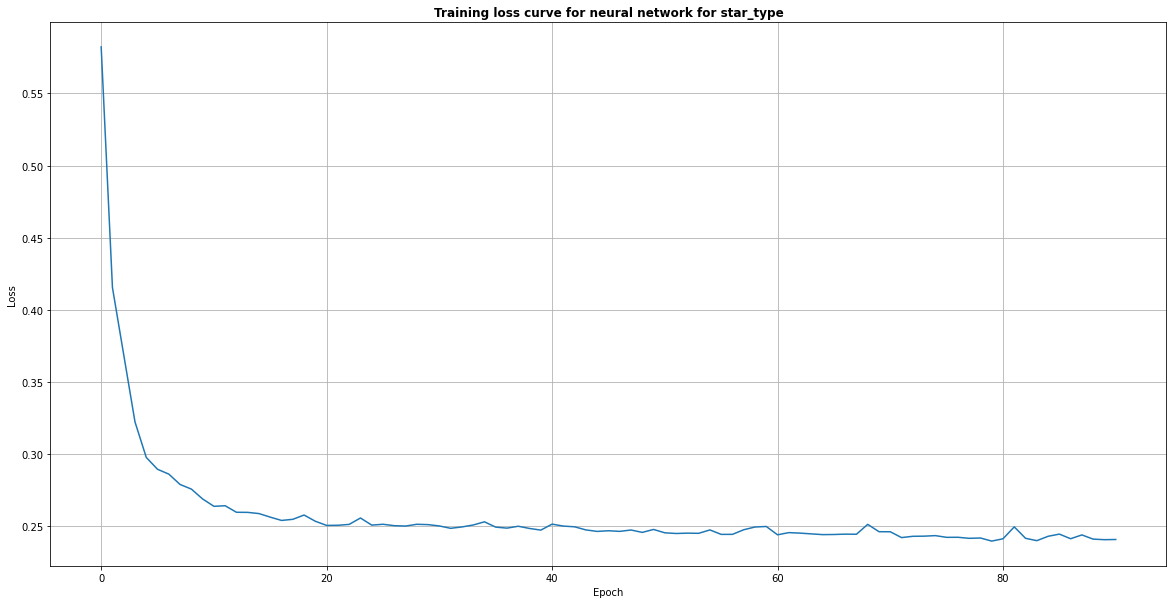

In [ ]:
    # Neural network learning
    training_time1, testing_time1 = neural_network_learning("wine_quality", X1, y1, saveFig=False, verbose= False)
    training_time2, testing_time2 = neural_network_learning("star_type", X2, y2, saveFig=False, verbose= False)
    model_type.append("Neural Network")
    training_time.append(training_time1 + training_time2)
    testing_time.append(testing_time1 + testing_time2)


AdaBoost learning

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_learning(dataset_name, X, y, saveFig=False, verbose=False):
    # Preprocessing the data
    X = preprocessing.scale(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an adaboost classifier using the default hyperparameters.
    ab = AdaBoostClassifier(n_estimators=50, random_state=0)
    ab.fit(X_train, y_train)
    y_test_pred = ab.predict(X_test)
    y_train_pred = ab.predict(X_train)
    report_training_result("adaboost (default)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Plot validation curves over hyperparameter n_estimators and learning_rate.
    # Validation curve help evaluate if the model is overfitting or underfitting.
    n_estimators_range = np.arange(2, 200, 1)
    train_score, test_score = validation_curve(ab, X_train, y_train, param_name="n_estimators",
                                               param_range=n_estimators_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(n_estimators_range, mean_train_score, label="Training score", color='b')
    plt.plot(n_estimators_range, mean_test_score, label="Cross-validation score", color='g')
    plt.grid()
    plt.title('Validataion curve for adaboost (n_estimators) for ' + dataset_name, fontweight="bold")
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.legend(loc = 'best')
    if saveFig:
        fig1 = plt.gcf()
        fig1.savefig('figure/ValidationCurve_ab(n_estimators)' + '_' + dataset_name +'.png', format='png', dpi=120)
        plt.close(fig1)
    else:
        plt.show()

    learning_rate_range = np.logspace(-5, 0, 6)
    train_score, test_score = validation_curve(ab, X_train, y_train,param_name="learning_rate",
                                               param_range=learning_rate_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.semilogx(learning_rate_range, mean_train_score, label='Training score' , color='c')
    plt.semilogx(learning_rate_range, mean_test_score, label='Cross-validation score', color='m')
    plt.grid()
    plt.title('Validataion curve for adaboost (learning_rate) for ' + dataset_name, fontweight="bold")
    plt.xlabel('learning_rate')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    if saveFig:
        fig2 = plt.gcf()
        fig2.savefig('figure/ValidationCurve_ab(learning_rate)' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig2)
    else:
        plt.show()

    # Plot learning curve to find out if the model would benefit from more training data.
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(ab, X_train, y_train,
                                                            train_sizes=train_sizes, cv=5)
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(train_sizes, mean_train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, mean_test_scores, 'o-', color='g', label='Cross-validation score')
    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.title('Learning curve for adaboost for ' + dataset_name, fontweight="bold")
    plt.legend(loc='best')
    if saveFig:
        fig3 = plt.gcf()
        fig3.savefig('figure/LearningCurve_ab' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig3)
    else:
        plt.show()

    # Tune the model over hyperparameter n_estimators and learning_rate.
    params_to_tune = {'n_estimators': n_estimators_range,
                      'learning_rate': learning_rate_range}
    grid_ab = GridSearchCV(estimator=ab, param_grid=params_to_tune, scoring='accuracy', cv=5, verbose=1, n_jobs=8)

    t0 = time.time()
    grid_ab.fit(X_train, y_train)
    t1 = time.time()
    training_time = t1 - t0
    print(f'Training time for adaboost classifier for {dataset_name}: {training_time} seconds')

    best_ab_params = grid_ab.best_params_
    print(f'The best adaboost parameters for {dataset_name} found are: {best_ab_params}')

    if verbose:
        print(f"Grid search scores on training data for {dataset_name}:")
        means = grid_ab.cv_results_['mean_test_score']
        stds = grid_ab.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_ab.cv_results_['params']):
            print(f"{'%0.3f' % (mean)} (+/-{'%0.03f' % (std * 2)}) for {'%r' % (params)}")

    t0 = time.time()
    y_test_pred = grid_ab.predict(X_test)
    t1 = time.time()
    testing_time = t1 - t0
    print(f'Inference time for adaboost classifier for {dataset_name}: {testing_time} seconds')

    y_train_pred = grid_ab.predict(X_train)

    report_training_result("adaboost (optimized)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    return training_time, testing_time



Classification report of adaboost (default) for wine_quality training data
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       603
           1       0.81      0.82      0.81       676

    accuracy                           0.80      1279
   macro avg       0.80      0.80      0.80      1279
weighted avg       0.80      0.80      0.80      1279

Classification report of adaboost (default) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       141
           1       0.78      0.75      0.77       179

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.75      0.74      0.74       320

Accuracy of adaboost (default) for wine_quality training data is 0.8014
Accuracy of adaboost (default) for wine_quality testing data is 0.7438
AUC of adaboost (default) for wine_quality training da

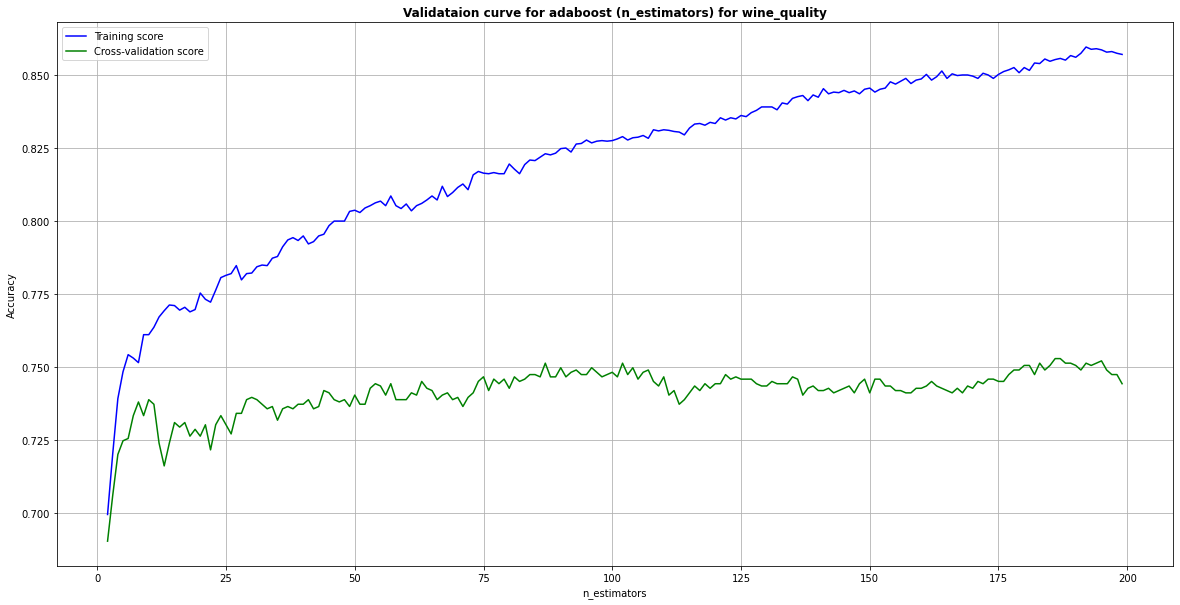

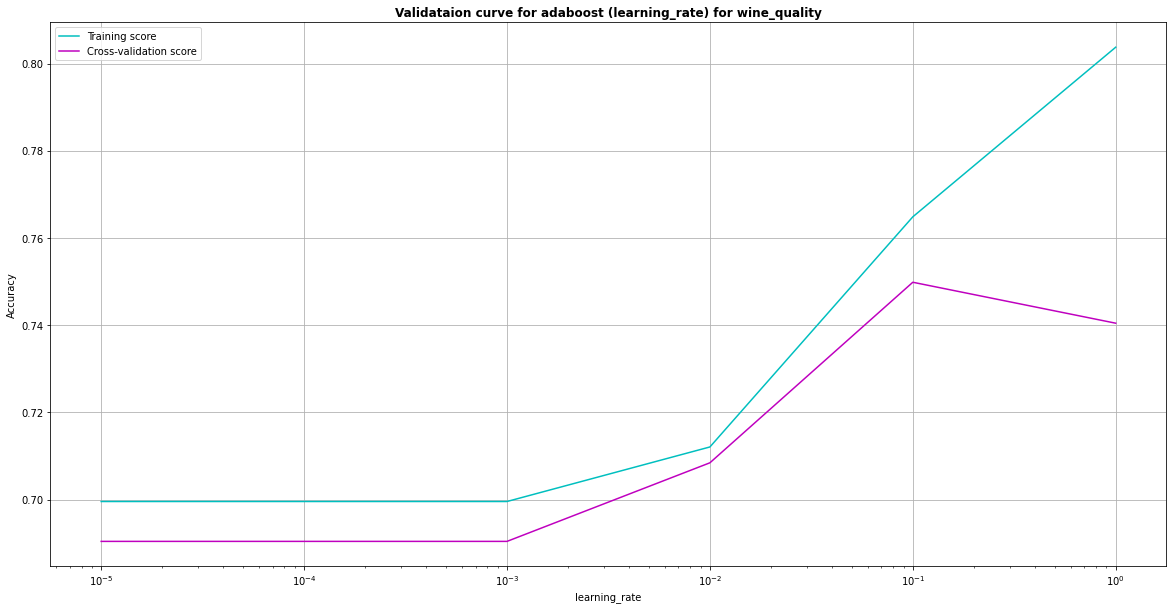

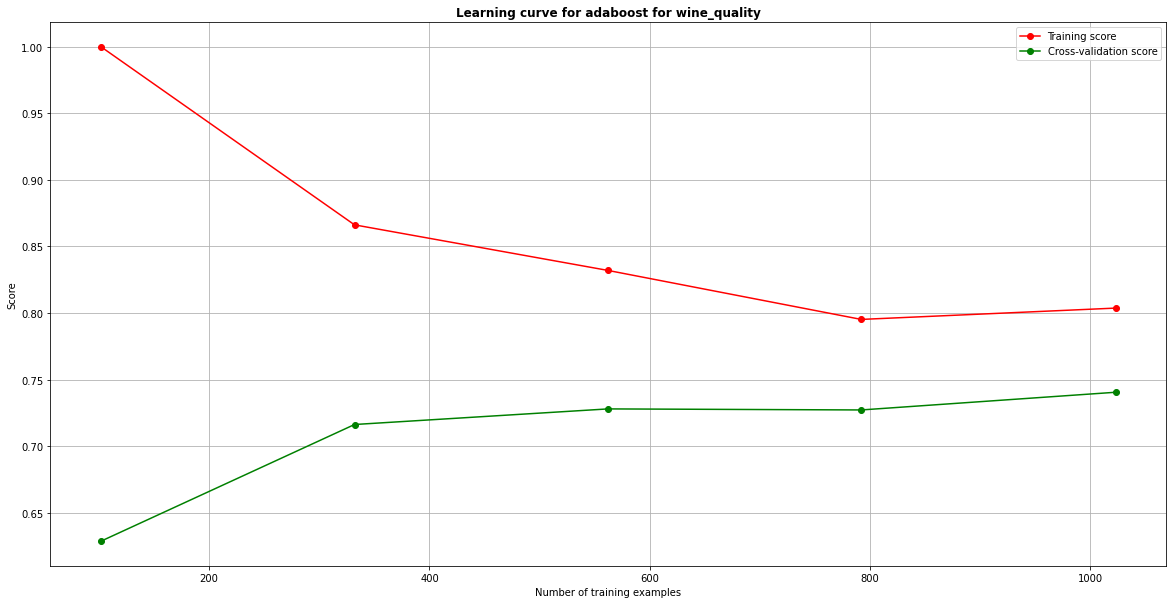

Fitting 5 folds for each of 1188 candidates, totalling 5940 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   48.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 11.3min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 14.9min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 18.5min
[Parallel(n_jobs=8)]: Done 5940 out of 5940 | elapsed: 22.2min finished


Training time for adaboost classifier for wine_quality: 1331.045661687851 seconds
The best adaboost parameters for wine_quality found are: {'learning_rate': 0.1, 'n_estimators': 62}
Inference time for adaboost classifier for wine_quality: 0.012064456939697266 seconds
Classification report of adaboost (optimized) for wine_quality training data
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       603
           1       0.78      0.78      0.78       676

    accuracy                           0.77      1279
   macro avg       0.77      0.77      0.77      1279
weighted avg       0.77      0.77      0.77      1279

Classification report of adaboost (optimized) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       141
           1       0.76      0.73      0.74       179

    accuracy                           0.72       320
   macro avg       0.71      0.71 

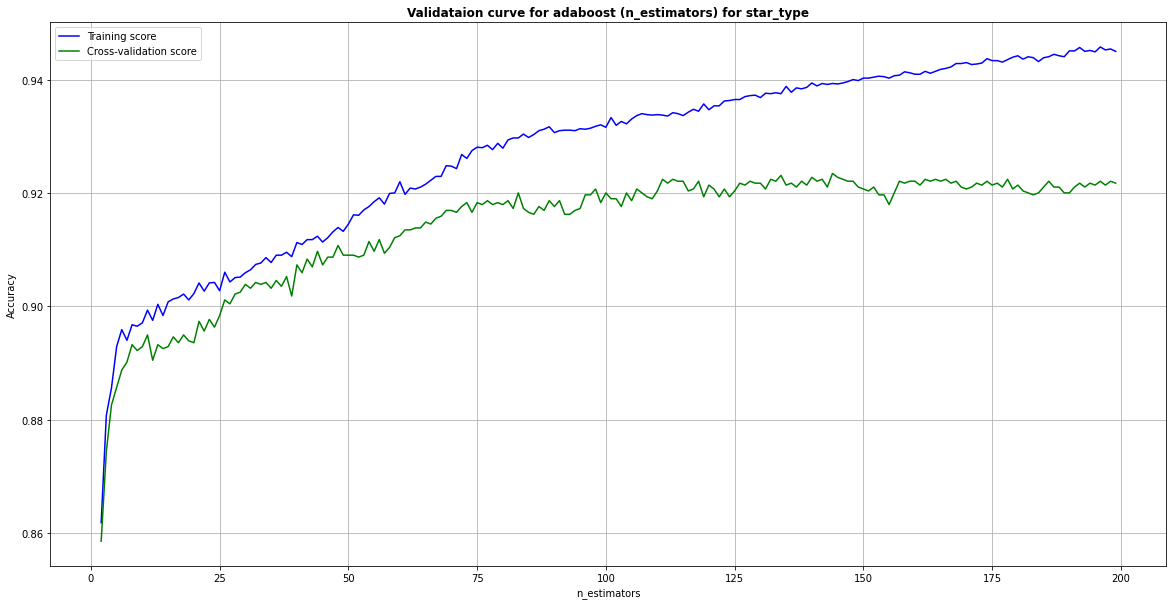

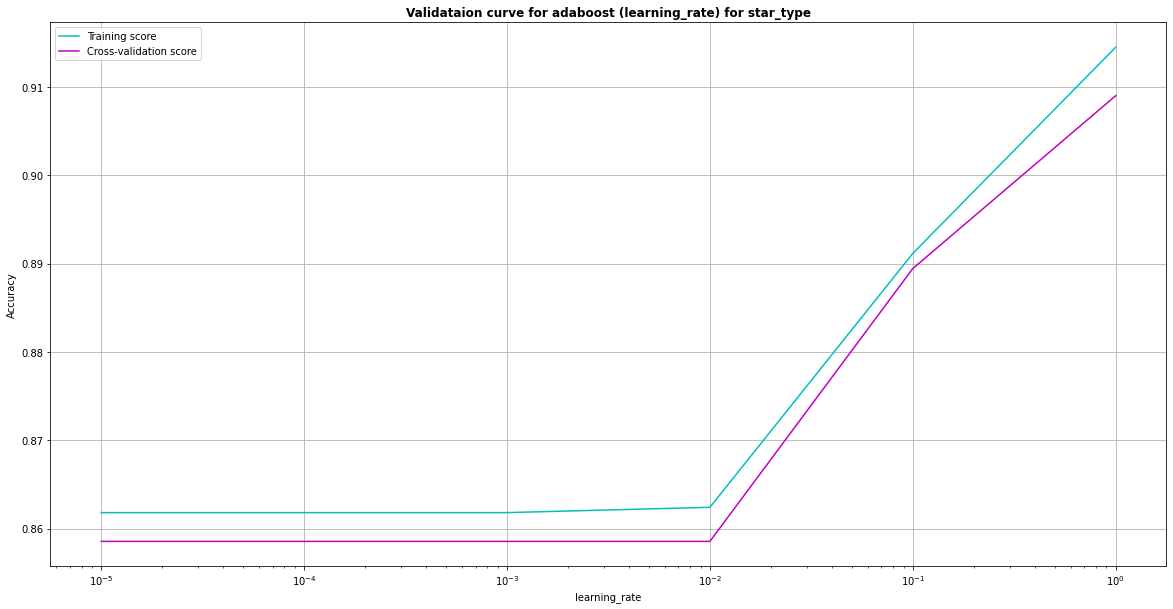

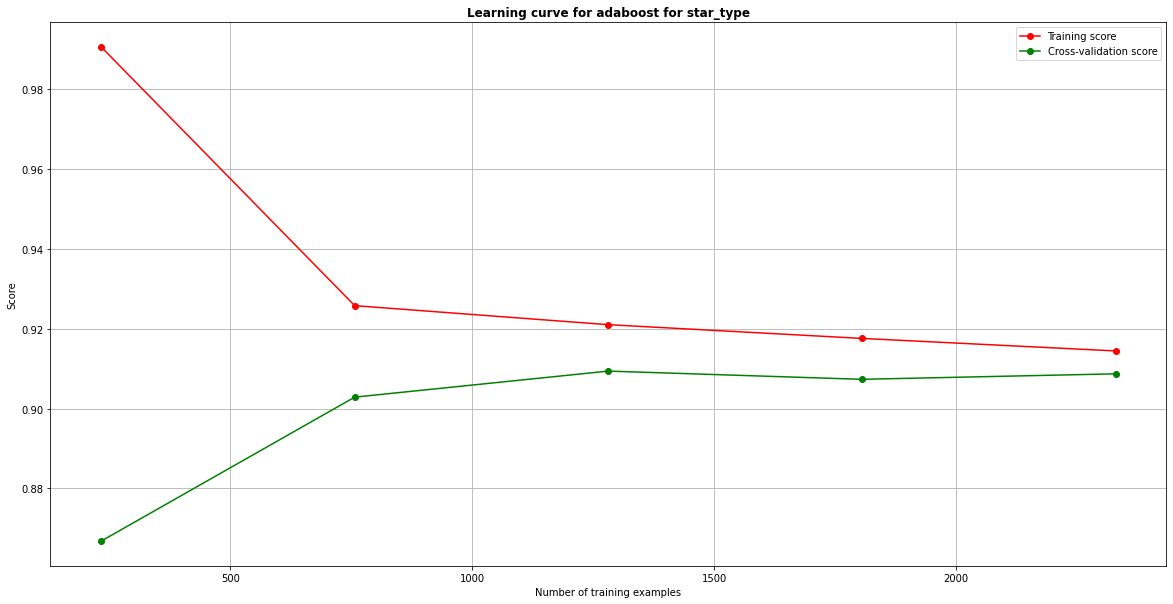

Fitting 5 folds for each of 1188 candidates, totalling 5940 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  8.5min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 11.3min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 15.5min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 20.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 25.4min
[Parallel(n_jobs=8)]: Done 5940 out of 5940 | elapsed: 30.4min finished


Training time for adaboost classifier for star_type: 1823.3505365848541 seconds
The best adaboost parameters for star_type found are: {'learning_rate': 1.0, 'n_estimators': 144}
Inference time for adaboost classifier for star_type: 0.03503108024597168 seconds
Classification report of adaboost (optimized) for star_type training data
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1468
           1       0.93      0.95      0.94      1445

    accuracy                           0.94      2913
   macro avg       0.94      0.94      0.94      2913
weighted avg       0.94      0.94      0.94      2913

Classification report of adaboost (optimized) for star_type testing data
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       353
           1       0.91      0.93      0.92       376

    accuracy                           0.92       729
   macro avg       0.92      0.92      0.92     

In [ ]:
    training_time1, testing_time1 = adaboost_learning("wine_quality", X1, y1, saveFig=False, verbose= False)
    training_time2, testing_time2 = adaboost_learning("star_type", X2, y2, saveFig=False, verbose= False)
    model_type.append("AdaBoost")
    training_time.append(training_time1 + training_time2)
    testing_time.append(testing_time1 + testing_time2)

SVM learning

In [ ]:
from sklearn.svm import SVC

def svm_learning(dataset_name, X, y, saveFig=False, verbose=False):
    # Preprocessing the data
    std_scaler = preprocessing.StandardScaler()
    X = std_scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use a linear kernel.
    svm = SVC(kernel='linear', random_state = 7)
    svm.fit(X_train, y_train)
    y_test_pred = svm.predict(X_test)
    y_train_pred = svm.predict(X_train)
    report_training_result("svm (linear)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Use a poly kernel.
    svm = SVC(kernel='poly', random_state = 7)
    svm.fit(X_train, y_train)
    y_test_pred = svm.predict(X_test)
    y_train_pred = svm.predict(X_train)
    report_training_result("svm (poly)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Plot validation curves over hyperparameter C.
    # Validation curve help evaluate if the model is overfitting or underfitting.
    C_range = np.logspace(-3, 3, 7)
    train_score, test_score = validation_curve(svm, X_train, y_train, param_name="C",
                                               param_range=C_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.semilogx(C_range, mean_train_score, label="Training score", color='b')
    plt.semilogx(C_range, mean_test_score, label="Cross-validation score", color='g')
    plt.grid()
    plt.title('Validataion curve for svm (C) for ' + dataset_name, fontweight="bold")
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.legend(loc = 'best')
    if saveFig:
        fig1 = plt.gcf()
        fig1.savefig('figure/ValidationCurve_svm(C)' + '_' + dataset_name +'.png', format='png', dpi=120)
        plt.close(fig1)
    else:
        plt.show()

    # Plot learning curve to find out if the model would benefit from more training data.
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(svm, X_train, y_train,
                                                            train_sizes=train_sizes, cv=5)
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(train_sizes, mean_train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, mean_test_scores, 'o-', color='g', label='Cross-validation score')
    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.title('Learning curve for svm for ' + dataset_name, fontweight="bold")
    plt.legend(loc='best')
    if saveFig:
        fig3 = plt.gcf()
        fig3.savefig('figure/LearningCurve_svm' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig3)
    else:
        plt.show()

    # Tune the model over hyperparameter C and kernel.
    kernel_range = ['linear', 'poly', 'rbf', 'sigmoid']
    params_to_tune = {'C': C_range, 'kernel': kernel_range}
    grid_svm = GridSearchCV(estimator=svm, param_grid=params_to_tune, scoring='accuracy', cv=5, verbose=1, n_jobs=8)

    t0 = time.time()
    grid_svm.fit(X_train, y_train)
    t1 = time.time()
    training_time = t1 - t0
    print(f'Training time for svm classifier for {dataset_name}: {training_time} seconds')

    best_svm_params = grid_svm.best_params_
    print(f'The best svm parameters for {dataset_name} found are: {best_svm_params}')

    if verbose:
        print(f"Grid search scores on training data for {dataset_name}:")
        means = grid_svm.cv_results_['mean_test_score']
        stds = grid_svm.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_svm.cv_results_['params']):
            print(f"{'%0.3f' % (mean)} (+/-{'%0.03f' % (std * 2)}) for {'%r' % (params)}")

    t0 = time.time()
    y_test_pred = grid_svm.predict(X_test)
    t1 = time.time()
    testing_time = t1 - t0
    print(f'Inference time for svm classifier for {dataset_name}: {testing_time} seconds')

    y_train_pred = grid_svm.predict(X_train)

    report_training_result("svm (optimized)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    return training_time, testing_time


Classification report of svm (linear) for wine_quality training data
              precision    recall  f1-score   support

           0       0.71      0.78      0.74       603
           1       0.79      0.72      0.75       676

    accuracy                           0.75      1279
   macro avg       0.75      0.75      0.75      1279
weighted avg       0.75      0.75      0.75      1279

Classification report of svm (linear) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       141
           1       0.80      0.69      0.74       179

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.74      0.73      0.73       320

Accuracy of svm (linear) for wine_quality training data is 0.7482
Accuracy of svm (linear) for wine_quality testing data is 0.7281
AUC of svm (linear) for wine_quality training data = 0.7499
AUC of svm (linear

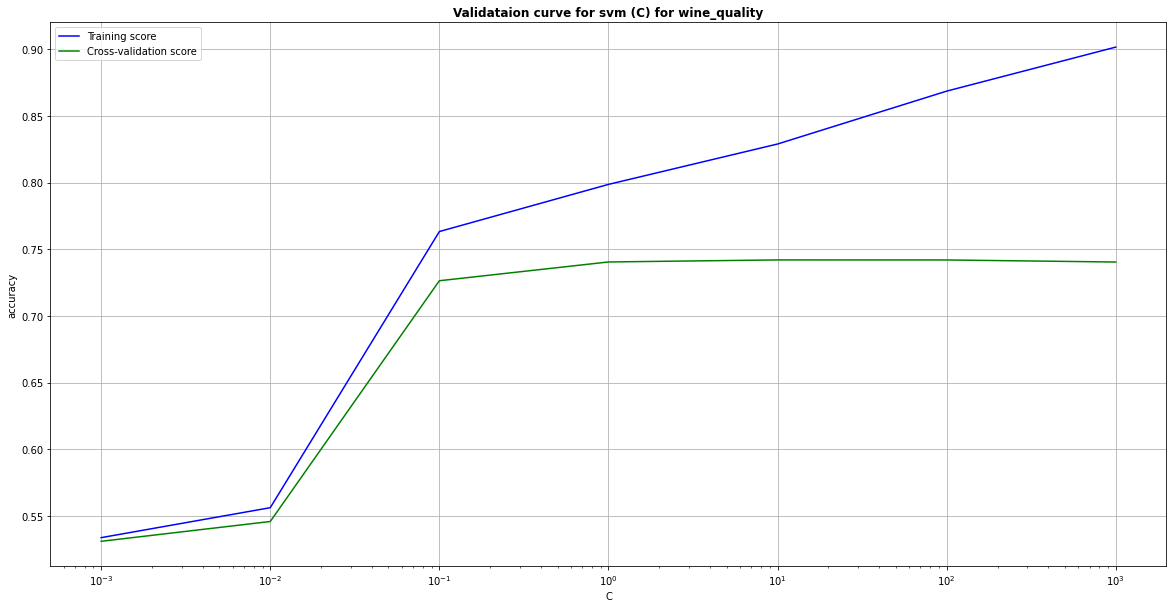

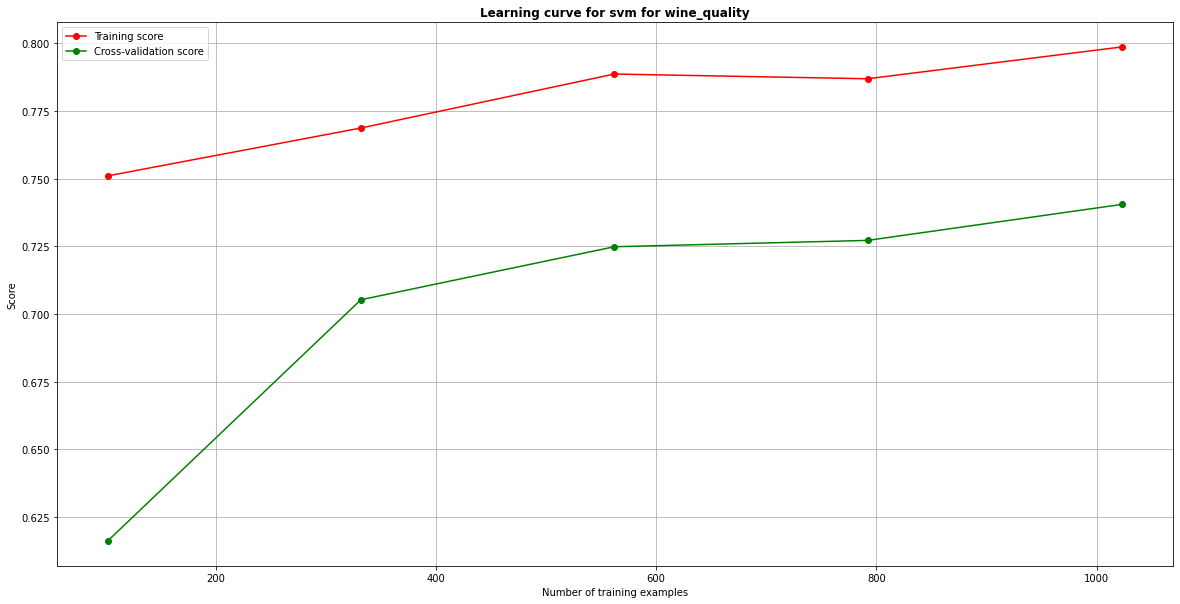

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  1.2min finished


Training time for svm classifier for wine_quality: 71.58688163757324 seconds
The best svm parameters for wine_quality found are: {'C': 10.0, 'kernel': 'rbf'}
Inference time for svm classifier for wine_quality: 0.009037017822265625 seconds
Classification report of svm (optimized) for wine_quality training data
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       603
           1       0.87      0.84      0.85       676

    accuracy                           0.85      1279
   macro avg       0.85      0.85      0.85      1279
weighted avg       0.85      0.85      0.85      1279

Classification report of svm (optimized) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       141
           1       0.80      0.77      0.79       179

    accuracy                           0.77       320
   macro avg       0.76      0.76      0.76       320
weighted avg       

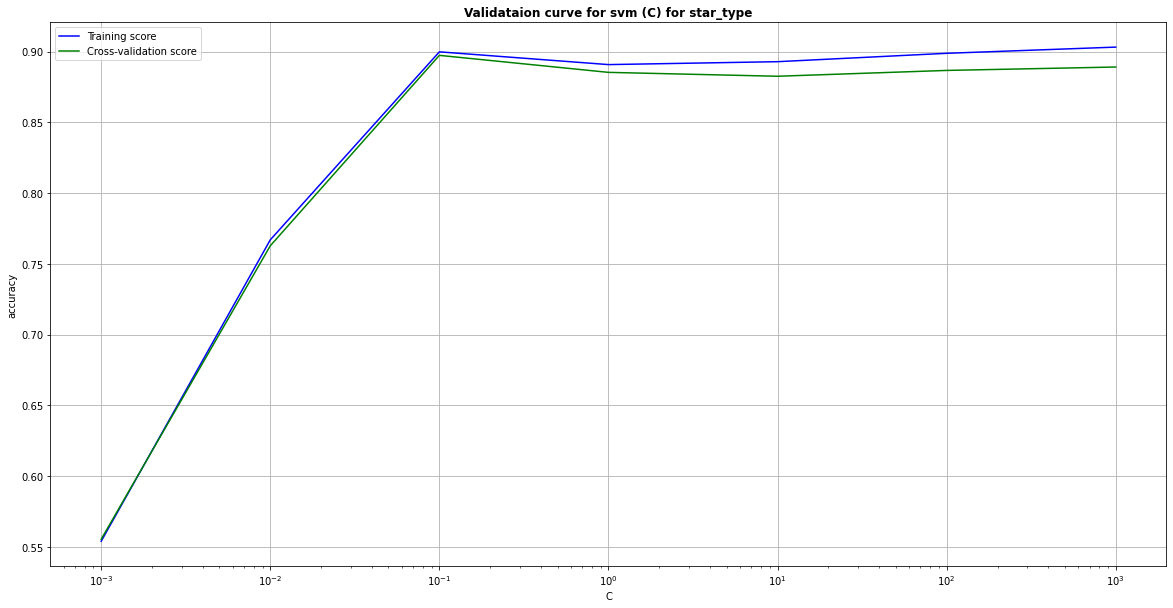

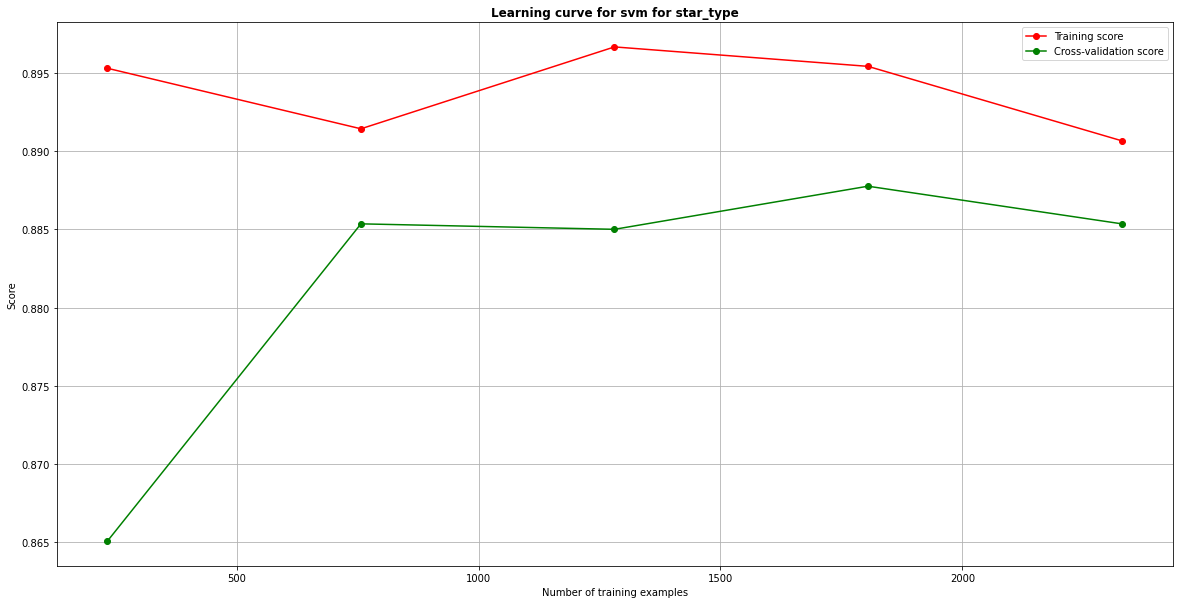

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:  1.3min finished


Training time for svm classifier for star_type: 80.92658996582031 seconds
The best svm parameters for star_type found are: {'C': 10.0, 'kernel': 'rbf'}
Inference time for svm classifier for star_type: 0.015807628631591797 seconds
Classification report of svm (optimized) for star_type training data
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1468
           1       0.92      0.91      0.91      1445

    accuracy                           0.92      2913
   macro avg       0.92      0.92      0.92      2913
weighted avg       0.92      0.92      0.92      2913

Classification report of svm (optimized) for star_type testing data
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       353
           1       0.89      0.88      0.89       376

    accuracy                           0.88       729
   macro avg       0.88      0.88      0.88       729
weighted avg       0.88      0.88 

In [ ]:
    training_time1, testing_time1 = svm_learning("wine_quality", X1, y1, saveFig=False, verbose= False)
    training_time2, testing_time2 = svm_learning("star_type", X2, y2, saveFig=False, verbose= False)
    model_type.append("SVM")
    training_time.append(training_time1 + training_time2)
    testing_time.append(testing_time1 + testing_time2)


KNN learning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def knn_learning(dataset_name, X, y, saveFig=False, verbose=False):
    # Preprocessing the data
    std_scaler = preprocessing.StandardScaler()
    minmax_scaler = preprocessing.MinMaxScaler()
    X = minmax_scaler.fit_transform(std_scaler.fit_transform(X))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Createa a KNN classifier and train it with the training data.
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    y_train_pred = knn.predict(X_train)
    report_training_result("knn", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    # Plot validation curves over hyperparameter n_neighbors.
    # Validation curve help evaluate if the model is overfitting or underfitting.
    n_neighbors_range = np.arange(1, 101)
    train_score, test_score = validation_curve(knn, X_train, y_train, param_name="n_neighbors",
                                               param_range=n_neighbors_range, cv=5)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(n_neighbors_range, mean_train_score, label="Training score", color='b')
    plt.plot(n_neighbors_range, mean_test_score, label="Cross-validation score", color='g')
    plt.grid()
    plt.title('Validataion curve for knn (n_neighbors) for ' + dataset_name, fontweight="bold")
    plt.xlabel('n_neighbors')
    plt.ylabel('accuracy')
    plt.legend(loc = 'best')
    if saveFig:
        fig1 = plt.gcf()
        fig1.savefig('figure/ValidationCurve_knn(n_neighbors)' + '_' + dataset_name +'.png', format='png', dpi=120)
        plt.close(fig1)
    else:
        plt.show()

    # Plot learning curve to find out if the model would benefit from more training data.
    train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train,
                                                            train_sizes=train_sizes, cv=5)
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_test_scores = np.mean(test_scores, axis=1)
    plt.figure(figsize=(20,10))
    plt.plot(train_sizes, mean_train_scores, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, mean_test_scores, 'o-', color='g', label='Cross-validation score')
    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.title('Learning curve for knn for ' + dataset_name, fontweight="bold")
    plt.legend(loc='best')
    if saveFig:
        fig3 = plt.gcf()
        fig3.savefig('figure/LearningCurve_knn' + '_' + dataset_name + '.png', format='png', dpi=120)
        plt.close(fig3)
    else:
        plt.show()

    # Tune the model over hyperparameter n_neighbors.
    params_to_tune = {'n_neighbors': n_neighbors_range}
    grid_knn = GridSearchCV(estimator=knn, param_grid=params_to_tune, scoring='accuracy', cv=5, verbose=1, n_jobs=8)

    t0 = time.time()
    grid_knn.fit(X_train, y_train)
    t1 = time.time()
    training_time = t1 - t0
    print(f'Training time for knn classifier for {dataset_name}: {training_time} seconds')

    best_knn_params = grid_knn.best_params_
    print(f'The best knn parameters for {dataset_name} found are: {best_knn_params}')

    if verbose:
        print(f"Grid search scores on training data for {dataset_name}:")
        means = grid_knn.cv_results_['mean_test_score']
        stds = grid_knn.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_knn.cv_results_['params']):
            print(f"{'%0.3f' % (mean)} (+/-{'%0.03f' % (std * 2)}) for {'%r' % (params)}")

    t0 = time.time()
    y_test_pred = grid_knn.predict(X_test)
    t1 = time.time()
    testing_time = t1 - t0
    print(f'Inference time for knn classifier for {dataset_name}: {testing_time} seconds')

    y_train_pred = grid_knn.predict(X_train)

    report_training_result("knn (optimized)", dataset_name,
                           y_train, y_train_pred, y_test, y_test_pred)

    return training_time, testing_time


Classification report of knn for wine_quality training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       676

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

Classification report of knn for wine_quality testing data
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       141
           1       0.77      0.80      0.78       179

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320

Accuracy of knn for wine_quality training data is 1.0000
Accuracy of knn for wine_quality testing data is 0.7531
AUC of knn for wine_quality training data = 1.0
AUC of knn for wine_quality testing data = 0.7462


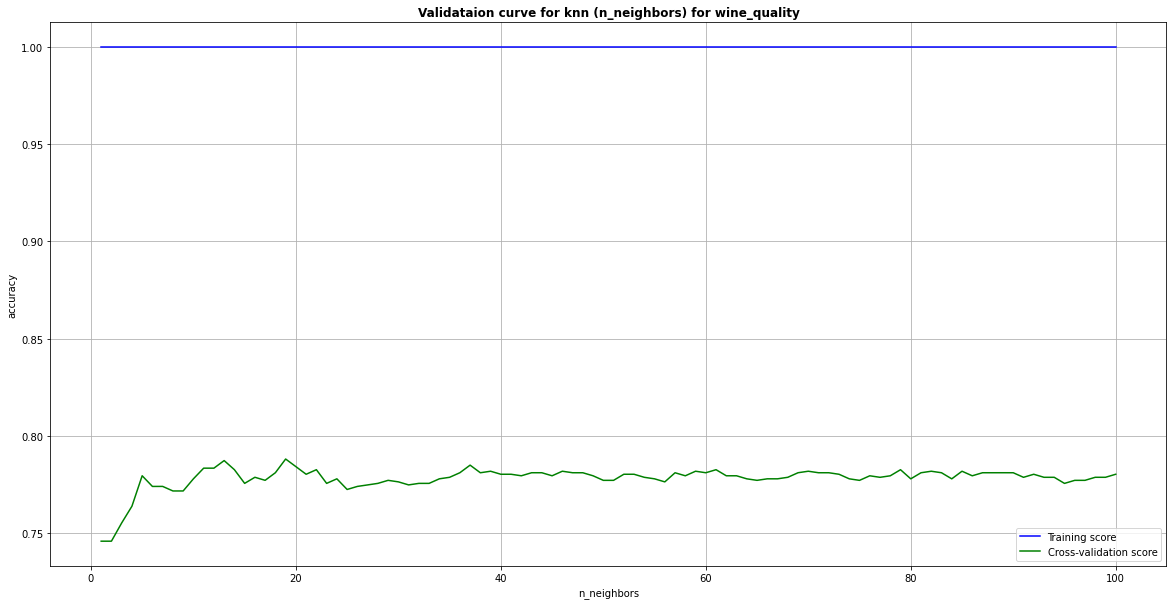

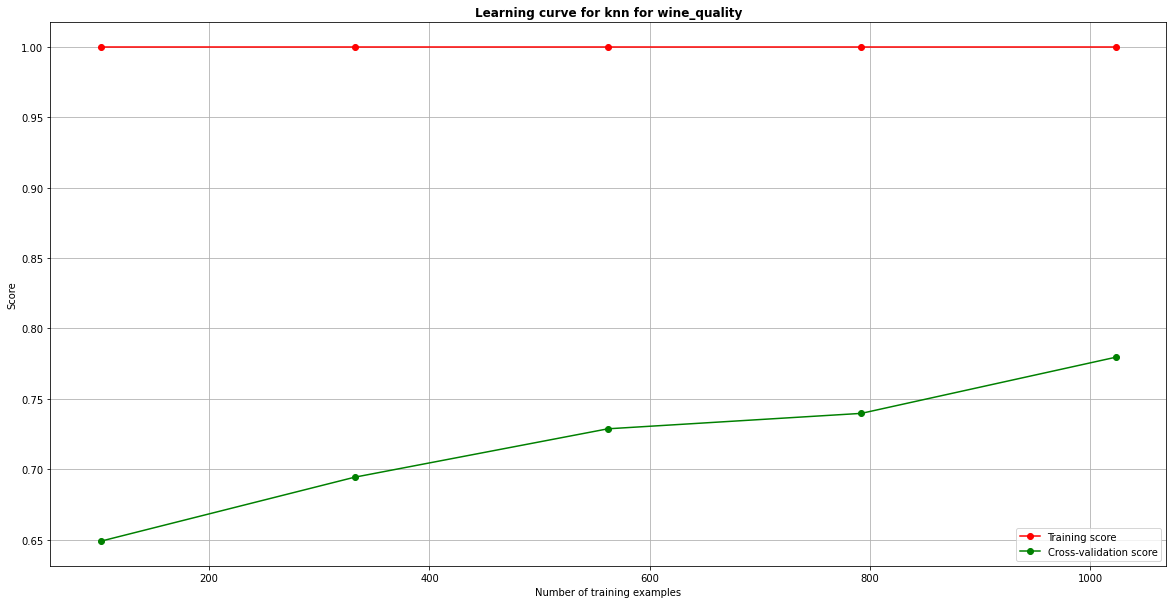

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 320 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    9.0s finished


Training time for knn classifier for wine_quality: 9.041595935821533 seconds
The best knn parameters for wine_quality found are: {'n_neighbors': 19}
Inference time for knn classifier for wine_quality: 0.01052236557006836 seconds
Classification report of knn (optimized) for wine_quality training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       676

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279

Classification report of knn (optimized) for wine_quality testing data
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       141
           1       0.81      0.80      0.81       179

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      

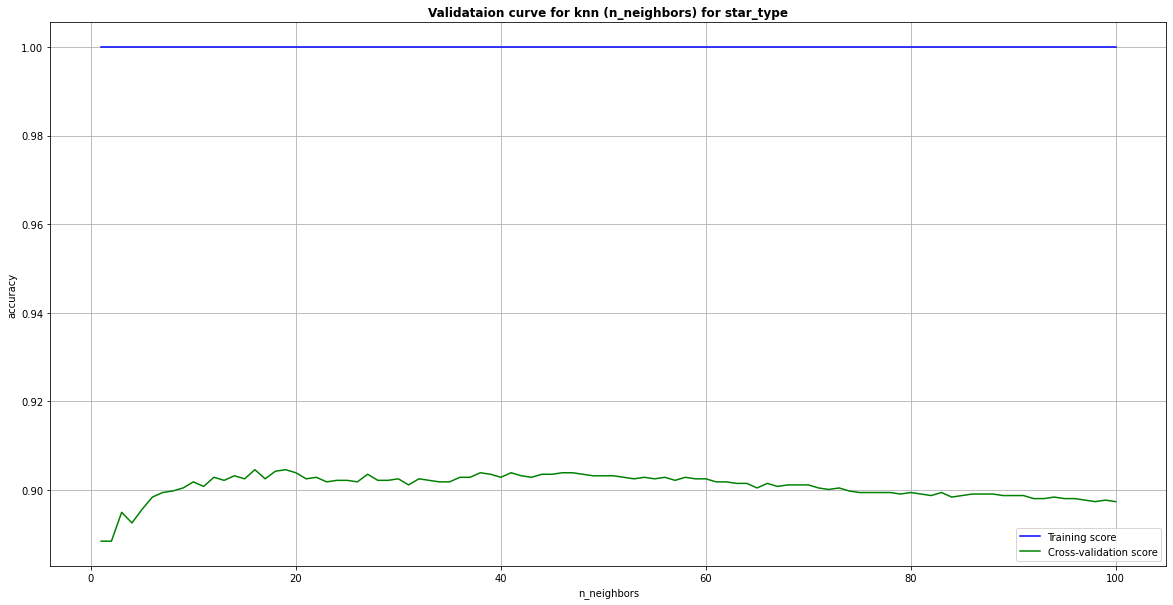

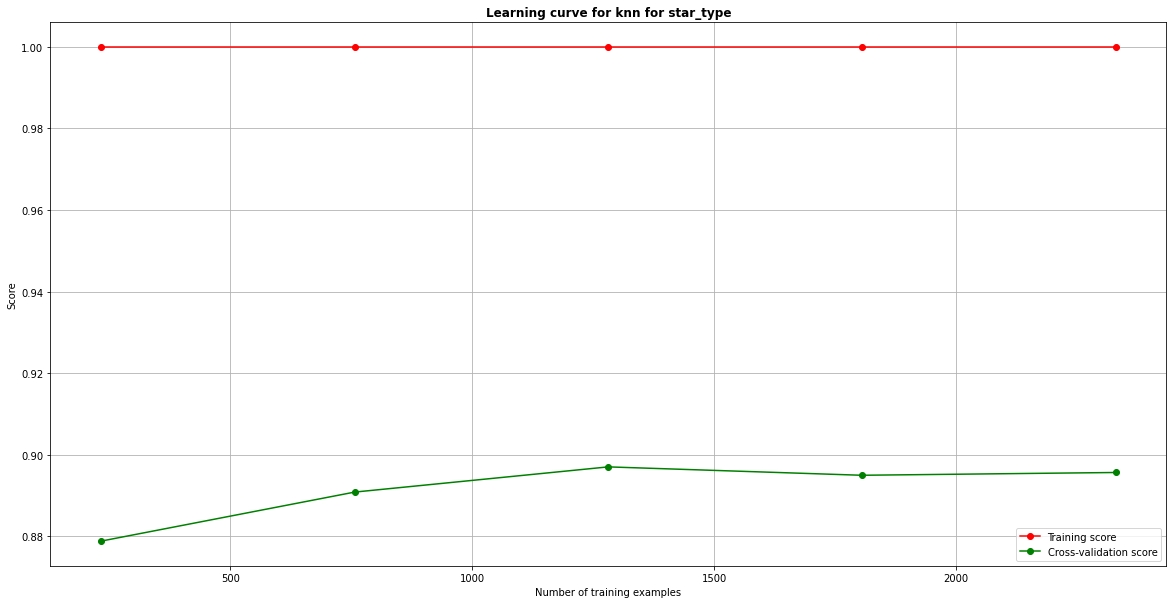

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  72 tasks      | elapsed:    0.8s


Training time for knn classifier for star_type: 7.175203800201416 seconds
The best knn parameters for star_type found are: {'n_neighbors': 16}
Inference time for knn classifier for star_type: 0.01265859603881836 seconds
Classification report of knn (optimized) for star_type training data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1468
           1       1.00      1.00      1.00      1445

    accuracy                           1.00      2913
   macro avg       1.00      1.00      1.00      2913
weighted avg       1.00      1.00      1.00      2913

Classification report of knn (optimized) for star_type testing data
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       353
           1       0.89      0.89      0.89       376

    accuracy                           0.89       729
   macro avg       0.89      0.89      0.89       729
weighted avg       0.89      0.89      0.89 

[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    7.2s finished


In [ ]:
    # KNN learning
    training_time1, testing_time1 = knn_learning("wine_quality", X1, y1, saveFig=False, verbose= False)
    training_time2, testing_time2 = knn_learning("star_type", X2, y2, saveFig=False, verbose= False)
    model_type.append("KNN")
    training_time.append(training_time1 + training_time2)
    testing_time.append(testing_time1 + testing_time2)
